## Setup

In [1]:
!pip install nltk
!pip install distrax

In [2]:
!git clone --depth 1 https://github.com/probml/pyprobml /pyprobml &> /dev/null
!curl -o bible.txt https://raw.githubusercontent.com/probml/probml-data/main/data/bible.txt
%cd -q /pyprobml/scripts

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4230k  100 4230k    0     0  9704k      0 --:--:-- --:--:-- --:--:-- 9704k


In [3]:
!pip install superimport

In [4]:
from conditional_bernoulli_mix_lib import ClassConditionalBMM
from conditional_bernoulli_mix_utils import (
    fake_test_data,
    encode,
    decode,
    get_decoded_samples,
    get_emnist_images_per_class,
)
from noisy_spelling_hmm import Word
from ngram_character_demo import ngram_model_fit, read_file, preprocessing, ngram_model_sample, ngram_loglikelihood
from distrax import HMM

from nltk.util import ngrams
from nltk import FreqDist, LidstoneProbDist

import numpy as np

import re
import string
from collections import defaultdict
from dataclasses import dataclass

from jax import vmap
import jax.numpy as jnp
import jax
from jax.random import PRNGKey, split
import distrax

import numpy as np
from matplotlib import pyplot as plt

## ClassConditionalBMM

In [5]:
select_n = 25
dataset, targets = get_emnist_images_per_class(select_n)
dataset, targets = jnp.array(dataset), jnp.array(targets)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
"""
During preprocessing of the text data, we removed punctuation whereas
case folding is not applied. The text data only contains
upper and lower case letters and hence there are 52 different characters
in total.
"""
n_char = 2 * 26

In [7]:
def get_bmm(n_mix, dataset, targets):

    mixing_coeffs = jnp.array(np.full((n_char, n_mix), 1.0 / n_mix))

    p_min, p_max = 0.4, 0.6
    n_pixels = 28 * 28
    probs = jnp.array(np.random.uniform(p_min, p_max, (n_char, n_mix, n_pixels)))

    class_priors = jnp.eye(n_char)

    class_cond_bmm = ClassConditionalBMM(
        mixing_coeffs=mixing_coeffs, probs=probs, class_priors=class_priors, n_char=n_char
    )
    _ = class_cond_bmm.fit_em(dataset, targets, 8)
    return class_cond_bmm.model

## HMM

In [8]:
def get_transition_probs(bigram):
    probs = np.zeros((52, 52))
    for prev, pd in bigram.prob_dists.items():
        if prev == " ":
            continue
        lowercase = prev.islower()
        i = lowercase * 26 + (ord(prev.lower()) - 97)
        for cur in pd.samples():
            if cur == " ":
                continue
            lowercase = cur.islower()
            j = lowercase * 26 + (ord(cur.lower()) - 97)
            probs[i, j] += pd.prob(cur)
    return probs

In [9]:
def init_hmm_from_bigram(bigram, bmm):
    init_dist = distrax.Categorical(logits=jnp.zeros((n_char,)))
    probs = get_transition_probs(bigram)
    trans_dist = distrax.Categorical(probs=probs)
    obs_dist = bmm
    hmm = HMM(init_dist, trans_dist, obs_dist)
    return hmm

## Loading Dataset

In [10]:
select_n = 25
dataset, targets = get_emnist_images_per_class(select_n)
dataset, targets = jnp.array(dataset), jnp.array(targets)

filepath = "/content/bible.txt"
text = read_file(filepath)
data = preprocessing(text, False)

## Sampling Images

In [11]:
n, n_mix = 2, 30
bigram = ngram_model_fit(n, data, smoothing=1)
bmm = get_bmm(n_mix, dataset, targets)
hmm = init_hmm_from_bigram(bigram, bmm)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [12]:
rng_key = PRNGKey(0)
seq_len = 6
Z, X = hmm.sample(seed=rng_key, seq_len=seq_len)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [13]:
def plot_seq(X, seq_len, figsize):
    fig, axes = plt.subplots(nrows=1, ncols=seq_len, figsize=figsize)
    for x, ax in zip(X, axes.flatten()):
        ax.imshow(x.reshape((28, 28)), cmap="gray")
    plt.tight_layout()
    plt.show()

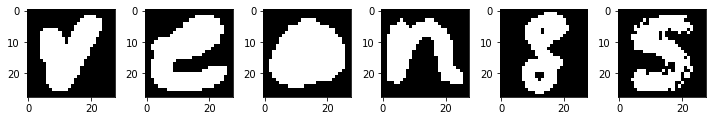

In [14]:
plot_seq(X, seq_len, (10, 8))

## NGram

In [15]:
n = 10
n_gram = ngram_model_fit(n, data, smoothing=1)

In [16]:
text_length = 11
prefix = "Christian"
Z = ngram_model_sample(n_gram, text_length, prefix)
log_p_Z = ngram_loglikelihood(n_gram, Z)

In [17]:
def sample_img_seq_given_char_seq(bmm, z, rng_key):
    LL = 0
    T = len(z)
    keys = split(rng_key, T)
    Xs = []
    for t, key in enumerate(keys):
        cur_char = z[t]
        X = jnp.zeros((784,))
        if cur_char != " ":
            lowercase = cur_char.islower()
            c = lowercase * 26 + (ord(cur_char.lower()) - 97)
            X = bmm.sample(seed=key)[c]
            log_p_X = bmm.log_prob(X)[c]

        Xs.append(X)

        LL += log_p_X

    return jnp.vstack(Xs), LL

In [18]:
rng_key = PRNGKey(0)
images, LL = sample_img_seq_given_char_seq(bmm, Z, rng_key)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [19]:
LL

DeviceArray(-374.44446, dtype=float32)

In [20]:
Z

'Christians first int'

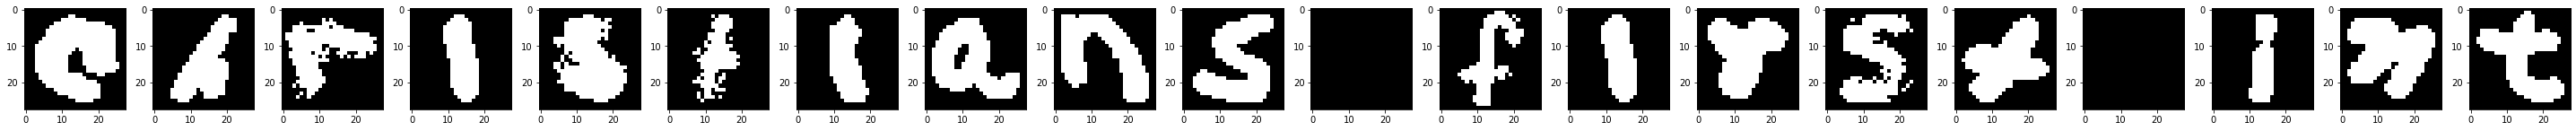

In [21]:
plot_seq(images, text_length + len(prefix), figsize=(40, 20))